## To do:
- Make data splitting in numpy by animal/group?
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.eeg_preprocessing import preprocess_recording_and_label

standardize = lambda x: (x - x.mean()) / x.std()

In [3]:
manifest = pd.read_csv("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/manifest.csv")  

In [4]:
results = []
for _, row in manifest.iterrows():
    print(f"Processing {row.get('animal_id', row['edf_path'])}")
    try:
        X, y, meta = preprocess_recording_and_label(
            edf_path=row["edf_path"],
            scoring_path=row["scoring_path"],
            eeg_band=(0.5, 45.0),
            emg_band=(10.0, 50.0),
            consensus_rule="priority",  # or "agree"
            resample_hz=128.0,
        )
        results.append({
            "cohort": row.get("cohort", None),
            "animal_id": row.get("animal_id", None),
            "epochs": X,
            "labels": y,
            "meta": meta,
        })
    except Exception as e:
        print(f"Failed on {row.get('animal_id', row['edf_path'])}: {e}")

Processing A1
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing A2
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing A3
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing A4
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing B1
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing B2
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing B3
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing B4
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing C1
Processing C2
Processing C3
Processing C4
Processing C5
Processing C6
Processing C7
Processing C8
Processing D1
Sampling frequency of the instance is already 128.0, returning unmodified.
Processing D2
Sampling frequency of the instance is already 128.0, returning unmodified

In [5]:
import numpy as np

def collate_results(results):
    """
    results: list of dicts with keys: 'epochs' (X_i), 'labels' (y_i), 'meta', 'animal_id', 'cohort'
    Returns:
        X  : (N, C, T) float32
        y  : (N,) int64
        groups : (N,) subject IDs (for GroupKFold)
        info : dict with channel names, sfreq, samples_per_epoch, cohorts per epoch, stage names
    """
    if not results:
        raise ValueError("results is empty")

    # Use the first recording as reference
    ref = results[0]["meta"]
    ref_ch = list(ref["ch_names"])
    ref_spe = int(ref["samples_per_epoch"])
    ref_sf  = float(ref["sfreq"])

    X_list, y_list, groups, cohorts = [], [], [], []
    for i, r in enumerate(results):
        X_i = r["epochs"]           # (n_i, C_i, T_i)
        y_i = r["labels"]           # (n_i,)
        m   = r["meta"]

        # Reorder channels to reference order if needed
        ch_i = list(m["ch_names"])
        if ch_i != ref_ch:
            try:
                reorder = [ch_i.index(ch) for ch in ref_ch]  # where each ref channel sits in this recording
            except ValueError as e:
                raise ValueError(f"Channel sets differ: expected {ref_ch}, got {ch_i}") from e
            X_i = X_i[:, reorder, :]

        # Append
        X_list.append(X_i.astype(np.float32, copy=False))
        y_list.append(np.asarray(y_i, dtype=np.int64))
        groups.extend([r.get("animal_id", f"rec{i}")] * len(y_i))
        cohorts.extend([r.get("cohort", None)] * len(y_i))

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    groups = np.asarray(groups)
    cohorts = np.asarray(cohorts, dtype=object)

    # (Optional) stage names per epoch using the first meta’s mapping
    inv_stage = {v: k for k, v in results[0]["meta"]["mapping"].items()}
    stage_names = np.array([inv_stage[int(lbl)] for lbl in y], dtype=object)

    info = {
        "ch_names": ref_ch,
        "sfreq": ref_sf,
        "samples_per_epoch": ref_spe,
        "groups": groups,          # subject IDs aligned to X/y
        "cohorts": cohorts,        # cohort per epoch
        "stage_names": stage_names # string labels aligned to y
    }
    return X, y, info

In [6]:
X, y, info = collate_results(results)

## Compute spectrograms

1. Compute spectrogram for each epoch

In [8]:
import os, math
import numpy as np
from scipy.signal import spectrogram
from lspopt import spectrogram_lspopt

def write_spectrogram_dataset(results, out_dir, nperseg, noverlap, multi_taper=False, fmin=0.0, fmax=None, eps=1e-10):
    os.makedirs(out_dir, exist_ok=True)
    # probe shapes from first item
    m0 = results[0]["meta"]
    sf = int(m0["sfreq"])
    n_ch = len(m0["ch_names"])
    T = int(m0["samples_per_epoch"])
    
    # Same parameters as Brodersen et al, 2024
    if multi_taper:
        f, t, Sxx = spectrogram_lspopt(np.zeros(T, np.float32), fs=sf, nperseg=sf, noverlap=None, c_parameter=20.0)
    else:
        f, t, Sxx = spectrogram(np.zeros(T, np.float32), fs=sf, window="hann",
                            nperseg=nperseg, noverlap=noverlap,
                            detrend=False, scaling="density", mode="psd")
        
    keep = (f >= fmin) & (f <= (sf/2.0 if fmax is None else fmax))
    F, TT = keep.sum(), len(t)

    # total epochs
    N = sum(len(r["labels"]) for r in results)

    # memmaps
    Xmm = np.memmap(os.path.join(out_dir, "spec_x.dat"), mode="w+", dtype=np.float32, shape=(N, n_ch, F, TT))
    ymm = np.memmap(os.path.join(out_dir, "spec_y.dat"), mode="w+", dtype=np.int64, shape=(N,))

    # iterate and fill
    idx = 0
    for r in results:
        print(f"Processing {r.get('animal_id')}")
        X = r["epochs"].astype(np.float32, copy=False)  # (n_i, C, T)
        y = r["labels"].astype(np.int64, copy=False)
        n_i = len(y)

        # compute per-epoch/channel
        for i in range(n_i):
            for c in range(n_ch):
                if multi_taper:
                    f, t, Sxx = spectrogram_lspopt(X[i, c], fs=sf, noverlap=None, c_parameter=20.0)
                else:
                    f, t, Sxx = spectrogram(X[i, c], fs=sf, window="hann",
                                        nperseg=nperseg, noverlap=noverlap,
                                        detrend=False, scaling="density", mode="psd")
                    
                Xmm[idx + i, c] = np.log10(Sxx[keep] + eps)
        ymm[idx:idx+n_i] = y
        idx += n_i

    meta = {
        "sfreq": sf, "channels": results[0]["meta"]["ch_names"],
        "nperseg": nperseg, "noverlap": noverlap,
        "f": f[keep], "t": t, "shape": Xmm.shape,
    }
    np.savez(os.path.join(out_dir, "spec_meta.npz"), **meta)
    # flush
    Xmm.flush(); ymm.flush()
    return str(Xmm.filename), str(ymm.filename), meta

In [10]:
import os
import numpy as np
from scipy.signal import spectrogram
from lspopt import spectrogram_lspopt

def write_spectrogram_dataset(results, out_dir, nperseg, noverlap,
                              multi_taper=False, fmin=0.5, fmax=None, eps=1e-10):
    os.makedirs(out_dir, exist_ok=True)

    # ---- Probe shapes from first item (with EXACT same params as compute) ----
    m0 = results[0]["meta"]
    sf = float(m0["sfreq"])
    n_ch = len(m0["ch_names"])
    T = int(m0["samples_per_epoch"])
    ny = sf / 2.0
    if fmax is None:
        fmax = ny

    x0 = np.zeros(T, np.float32)
    if multi_taper:
        f_probe, t_probe, S0 = spectrogram_lspopt(
            x0, fs=sf, nperseg=nperseg, noverlap=noverlap, c_parameter=20.0
        )
    else:
        f_probe, t_probe, S0 = spectrogram(
            x0, fs=sf, window="hann", nperseg=nperseg, noverlap=noverlap,
            detrend=False, scaling="density", mode="psd"
        )

    keep = (f_probe >= fmin) & (f_probe <= fmax)
    F, TT = int(keep.sum()), int(len(t_probe))

    # ---- Allocate memmaps ----
    N = sum(len(r["labels"]) for r in results)
    Xmm = np.memmap(os.path.join(out_dir, "spec_x.dat"), mode="w+",
                    dtype=np.float32, shape=(N, n_ch, F, TT))
    ymm = np.memmap(os.path.join(out_dir, "spec_y.dat"), mode="w+",
                    dtype=np.int64,   shape=(N,))

    # ---- Iterate and fill ----
    idx = 0
    for r in results:
        print(f"Processing {r.get('animal_id')}")
        X = r["epochs"].astype(np.float32, copy=False)  # (n_i, C, T)
        y = r["labels"].astype(np.int64, copy=False)
        n_i = len(y)

        for i in range(n_i):
            for c in range(n_ch):
                if multi_taper:
                    f, t, Sxx = spectrogram_lspopt(
                        X[i, c], fs=sf, nperseg=nperseg, noverlap=noverlap, c_parameter=20.0
                    )
                else:
                    f, t, Sxx = spectrogram(
                        X[i, c], fs=sf, window="hann", nperseg=nperseg, noverlap=noverlap,
                        detrend=False, scaling="density", mode="psd"
                    )
                # same keep mask as probe
                Xmm[idx + i, c] = np.log10(Sxx[keep] + eps)

        ymm[idx:idx + n_i] = y
        idx += n_i

    # ---- Save meta (from probe) ----
    meta = {
        "sfreq": sf,
        "channels": results[0]["meta"]["ch_names"],
        "method": "lspopt" if multi_taper else "stft",
        "multi_taper": bool(multi_taper),
        "c_parameter": 20.0 if multi_taper else None,
        "nperseg": int(nperseg),
        "noverlap": int(noverlap),
        "f": f_probe[keep].astype(np.float32),
        "t": t_probe.astype(np.float32),
        "shape": Xmm.shape,
    }
    np.savez(os.path.join(out_dir, "spec_meta.npz"), **meta)
    Xmm.flush(); ymm.flush()
    return str(Xmm.filename), str(ymm.filename), meta


In [13]:
SPECTRO_OUTPUT_DIR = Path("data/mt_spectrogram_128_0")
X_filename, y_filename, meta = write_spectrogram_dataset(results, 
                                                        out_dir=SPECTRO_OUTPUT_DIR,
                                                        nperseg=128,
                                                        noverlap=0,
                                                        multi_taper=True
                                                        )

Processing A1
Processing A2
Processing A3
Processing A4
Processing B1
Processing B2
Processing B3
Processing B4
Processing C1
Processing C2
Processing C3
Processing C4
Processing C5
Processing C6
Processing C7
Processing C8
Processing D1
Processing D2
Processing D3
Processing D4
Processing D5
Processing D6


## Split data into train, eval and test

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

def make_group_splits(y, groups, n_splits=5, random_state=0, test_fold=0, val_fold=1):
    """
    y:        (N,) int labels
    groups:   (N,) array-like of animal IDs (strings or ints)
    Returns:  train_idx, val_idx, test_idx (disjoint index arrays)
    """
    y = np.asarray(y)
    groups = np.asarray(groups)

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    folds = list(sgkf.split(np.zeros_like(y), y, groups))  # each item: (train_idx, test_idx_for_that_fold)

    idx_test = folds[test_fold][1]
    idx_val  = folds[val_fold][1]
    all_idx  = np.arange(len(y))
    idx_train = np.setdiff1d(all_idx, np.union1d(idx_test, idx_val), assume_unique=False)

    # sanity: no animal appears in more than one split
    assert set(groups[idx_train]).isdisjoint(groups[idx_val])
    assert set(groups[idx_train]).isdisjoint(groups[idx_test])
    assert set(groups[idx_val]).isdisjoint(groups[idx_test])

    return idx_train, idx_val, idx_test

In [15]:
# Load your spectrogram memmaps (or arrays)
SPECTRO_OUTPUT_DIR = "data/spectra_mt_1s_nooverlap"
N, C, F, TT = meta['shape']
Xmm = np.memmap(os.path.join(SPECTRO_OUTPUT_DIR,"spec_x.dat"), mode="r", dtype=np.float32, shape=(N, C, F, TT))
ymm = np.memmap(os.path.join(SPECTRO_OUTPUT_DIR,"spec_y.dat"), mode="r", dtype=np.int64,   shape=(N,))

# Load groups (animal IDs) you saved earlier alongside the specs
groups = info['groups']  # shape (N,)
idx_tr, idx_va, idx_te = make_group_splits(ymm, groups, n_splits=5, random_state=42)

# Slice the memmaps (this does not load everything into RAM at once)
X_tr, y_tr_enc = Xmm[idx_tr], ymm[idx_tr]
X_va, y_va_enc = Xmm[idx_va], ymm[idx_va]
X_te, y_te_enc = Xmm[idx_te], ymm[idx_te]

print("Train/Val/Test:", X_tr.shape, X_va.shape, X_te.shape)

Train/Val/Test: (215982, 3, 64, 4) (78505, 3, 64, 4) (77816, 3, 64, 4)


In [16]:
import numpy as np

def animals_in_split(groups, idx):
    g = np.asarray(groups)
    u, counts = np.unique(g[idx], return_counts=True)
    return u, counts  # unique animal IDs and their epoch counts

train_animals, train_counts = animals_in_split(groups, idx_tr)
val_animals,   val_counts   = animals_in_split(groups, idx_va)
test_animals,  test_counts  = animals_in_split(groups, idx_te)

print("Train: n_animals =", len(train_animals))
print("Val:   n_animals =", len(val_animals))
print("Test:  n_animals =", len(test_animals))

# (optional) peek the lists
print("Train animals:", train_animals[:10])
print("Val animals:  ", val_animals[:10])
print("Test animals: ", test_animals[:10])

Train: n_animals = 13
Val:   n_animals = 4
Test:  n_animals = 5
Train animals: ['A2' 'B1' 'B3' 'B4' 'C1' 'C4' 'C5' 'C6' 'C7' 'C8']
Val animals:   ['A1' 'B2' 'D3' 'D5']
Test animals:  ['A3' 'A4' 'C2' 'C3' 'D6']


In [17]:
def label_ratios(y, idx):
    vals, cnts = np.unique(np.asarray(y)[idx], return_counts=True)
    return {int(v): c/sum(cnts) for v, c in zip(vals, cnts)}

print(f"Train labels: {label_ratios(y, idx_tr)}")
print("Val labels:  ", label_ratios(y, idx_va))
print("Test labels: ", label_ratios(y, idx_te))

Train labels: {0: np.float64(0.3451306127362465), 1: np.float64(0.5634960320767471), 2: np.float64(0.09137335518700633)}
Val labels:   {0: np.float64(0.4766320616521241), 1: np.float64(0.44640468759951596), 2: np.float64(0.07696325074835998)}
Test labels:  {0: np.float64(0.38769661766217745), 1: np.float64(0.5269738871183304), 2: np.float64(0.08532949521949214)}


## Data normalization

In [18]:
# Fit μ,σ on TRAIN ONLY, per (channel, frequency)
def fit_cf_norm(Xmm, idx, eps=1e-6):
    # Xmm: (N, C, F, T)
    mu = Xmm[idx].mean(axis=(0, 3), dtype=np.float64)                    # (C,F)
    var= Xmm[idx].var(axis=(0, 3), dtype=np.float64)
    std= np.sqrt(np.maximum(var, eps))
    return mu.astype(np.float32), std.astype(np.float32)

def apply_cf_norm(X, mu, std):
    # X: (..., C, F, T)
    return (X - mu[None, :, :, None]) / (std[None, :, :, None] + 1e-6)

mu_cf, std_cf = fit_cf_norm(Xmm, idx_tr)
X_tr_z = apply_cf_norm(X_tr, mu_cf, std_cf)
X_va_z = apply_cf_norm(X_va, mu_cf, std_cf)
X_te_z = apply_cf_norm(X_te, mu_cf, std_cf)

In [19]:
import numpy as np

def class_means(Xz, y, label, axis=(0,3)):  # mean over epochs/time
    return Xz[y==label].mean(axis=axis)     # (C,F)

# Example: compare NREM vs Wake theta band on EEG
f = meta['f']
theta = (f>=4) & (f<=8)
m_wake = class_means(X_tr_z, y_tr_enc, 2)[:, theta].mean(axis=1)   # 2=Wake
m_nrem = class_means(X_tr_z, y_tr_enc, 1)[:, theta].mean(axis=1)   # 1=NREM
print("Theta z-score (Wake, NREM) per EEG ch:", m_wake[:2], m_nrem[:2])

Theta z-score (Wake, NREM) per EEG ch: [-0.36487657 -0.3540001 ] [0.04231074 0.04276265]


## Aggregate spectrograms along time-axis

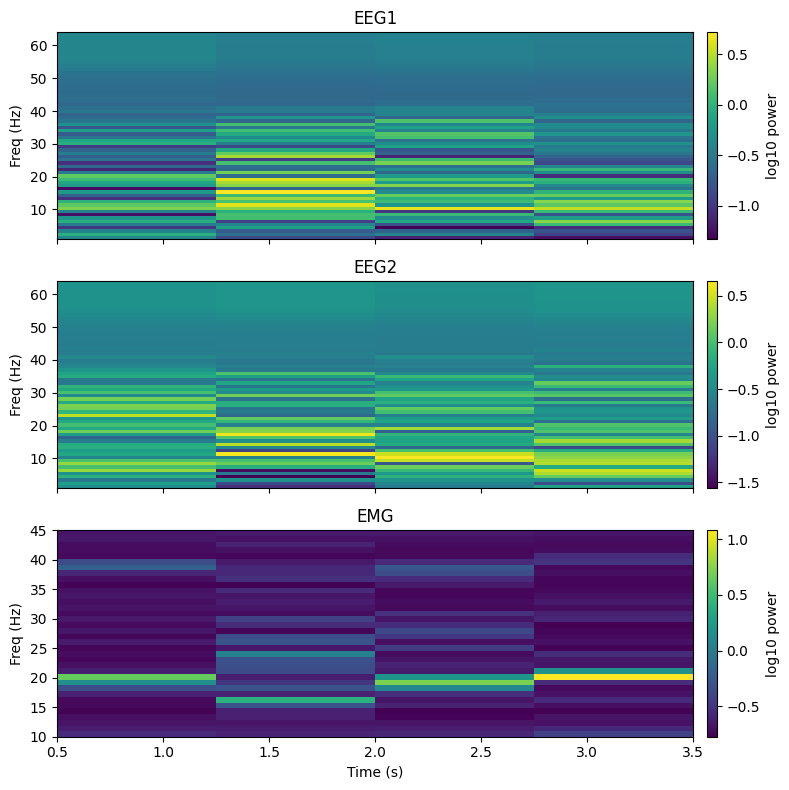

In [20]:
import numpy as np
import matplotlib.pyplot as plt

i = int(idx_tr[0])
S = X_tr_z[i]                      # (C, F, T)
t = meta['t']
f = meta['f']
ch_names = list(meta['channels'])

# find EMG channel index
emg_idx = ch_names.index("EMG")

# frequency mask for EMG band
fmask_emg = (f >= 10) & (f <= 45)

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for ch, ax in enumerate(axes):
    # per-channel color range
    vmin, vmax = S[ch].min(), S[ch].max()
    if ch == emg_idx:
        data = S[ch][fmask_emg]       # show only 10–45 Hz
        f_plot = f[fmask_emg]
    else:
        data = S[ch]                  # full EEG band (e.g., 0.5–40/64 Hz)
        f_plot = f

    im = ax.imshow(
        data, aspect="auto", origin="lower",
        extent=[t[0], t[-1], f_plot[0], f_plot[-1]],
        vmin=vmin, vmax=vmax
    )
    ax.set_ylabel("Freq (Hz)")
    ax.set_title(ch_names[ch])
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02, label="log10 power")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout(); plt.show()

### Multi-taper spectrogram as previous studies do

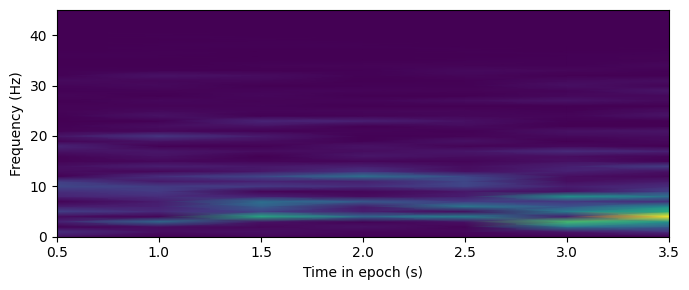

In [21]:
from scipy.signal import spectrogram
x = X[0,0,:]
f, t, Sxx = spectrogram(x, fs=128, nperseg=128, noverlap=64,
                        detrend=False, scaling="density", mode="psd")

plt.figure(figsize=(7, 3))
plt.pcolormesh(t, f, Sxx, shading="gouraud")
plt.ylabel("Frequency (Hz)"); plt.xlabel("Time in epoch (s)")
plt.ylim(0, 45); plt.tight_layout(); plt.show()

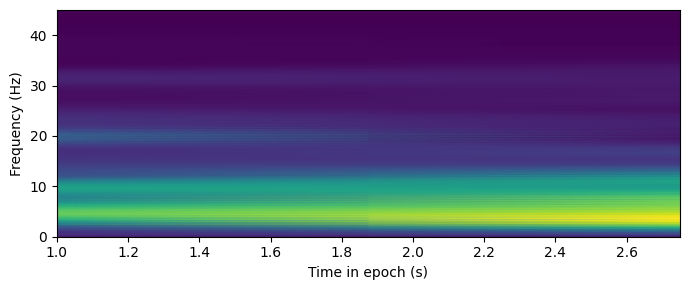

In [22]:
from lspopt import spectrogram_lspopt
f, t, Sxx = spectrogram_lspopt(x, 128, c_parameter=20.0)
plt.figure(figsize=(7, 3))
plt.pcolormesh(t, f, Sxx, shading="gouraud")
plt.ylabel("Frequency (Hz)"); plt.xlabel("Time in epoch (s)")
plt.ylim(0, 45); plt.tight_layout(); plt.show()

In [23]:
import numpy as np

def make_logistic_regression_input(X, ch_idx=None, agg="mean"):
    """
    X: (N, C, F, T) spectrograms (log-power)
    ch_idx: list of channel indices in the order you want to stack,
            e.g. [0,1,2] for [EEG1, EEG2, EMG]. Default = all in current order.
    agg: reduction over time axis, "mean" (default) or "median"
    Returns:
        X_lr: (N, F * len(ch_idx)) float32
              columns are [chan0_freqs | chan1_freqs | ...]
    """
    if X.ndim != 4:
        raise ValueError(f"Expected X with shape (N,C,F,T), got {X.shape}")

    N, C, F, T = X.shape
    if ch_idx is None:
        ch_idx = list(range(C))

    # reduce over time
    if agg == "mean":
        X_red = X[:, ch_idx].mean(axis=-1)         # (N, len(ch_idx), F)
    elif agg == "median":
        X_red = np.median(X[:, ch_idx], axis=-1)    # (N, len(ch_idx), F)
    else:
        raise ValueError('agg must be "mean" or "median"')

    # stack channels as columns: (N, len(ch_idx)*F)
    X_lr = X_red.reshape(N, -1).astype(np.float32, copy=False)
    return X_lr

In [24]:
# assuming channel order in X is [EEG1, EEG2, EMG]
ch_idx=[0,1,2]
X_tr_lr = make_logistic_regression_input(X_tr_z, ch_idx, agg="mean")
X_va_lr = make_logistic_regression_input(X_va_z, ch_idx, agg="mean")
X_te_lr = make_logistic_regression_input(X_te_z, ch_idx, agg="mean")

print(X_tr.shape)    # (N, 3, F, 7)
print(X_tr_lr.shape) # (N, 3*F)


(215982, 3, 64, 4)
(215982, 192)


In [25]:
def flatten_specs(X, ch_idx=None):  # (N, C, F, T) -> (N, C*F*T)
    if ch_idx is not None:
        X = X[:, ch_idx, :, :]
    return X.reshape(X.shape[0], -1).astype(np.float32)

ch_idx=[0,1,2]
X_tr_xgb = flatten_specs(X_tr_z, ch_idx)
X_va_xgb = flatten_specs(X_va_z, ch_idx)
X_te_xgb = flatten_specs(X_te_z, ch_idx)

print(X_tr.shape)
print(X_tr_xgb.shape)

(215982, 3, 64, 4)
(215982, 768)


# Models

In [138]:
from src.evaluate_predictions import make_val_df, subset_window, plot_hypnogram_window, plot_confusion_matrix, smooth_by_animal

from sklearn.metrics import classification_report
from src.prediction_utils import decode_stages

CLASS_ORDER = ["Wake", "NREM", "REM"]  # adjust if needed
INT_TO_STAGE = {0:"Wake", 1:"NREM", 2:"REM"}

def evaluate_model(y_pred, y_true, eval_smoothed=True, median_kernel=5):

    # decoding
    y_pred_dec = decode_stages(y_pred)
    y_true_dec = decode_stages(y_true)

    print(f'----- RAW PREDICTIONS -----')
    print(classification_report(
        y_true_dec, y_pred_dec,
        labels=CLASS_ORDER,
        digits=3,
        zero_division=0            
    ))

    plot_confusion_matrix(y_true_dec, y_pred_dec, labels=CLASS_ORDER, normalize='true')

    if eval_smoothed:
        y_pred_smoothed = smooth_by_animal(y_pred, groups=info['groups'][idx_te], width=median_kernel)
        y_pred_smoothed_dec = decode_stages(y_pred_smoothed)

        print(f'----- SMOOTHED PREDICTIONS (median kernel={median_kernel}) -----')
        print(classification_report(
            y_true_dec, y_pred_smoothed_dec,
            labels=CLASS_ORDER,
            digits=3,
            zero_division=0            
        ))

        plot_confusion_matrix(y_true_dec, y_pred_smoothed_dec, labels=CLASS_ORDER, normalize='true')

    return y_pred, y_pred_smoothed if eval_smoothed else None

## Logistic Regression

----- RAW PREDICTIONS -----
              precision    recall  f1-score   support

        Wake      0.956     0.921     0.938     37418
        NREM      0.938     0.876     0.906     35045
         REM      0.520     0.834     0.640      6042

    accuracy                          0.894     78505
   macro avg      0.804     0.877     0.828     78505
weighted avg      0.914     0.894     0.901     78505



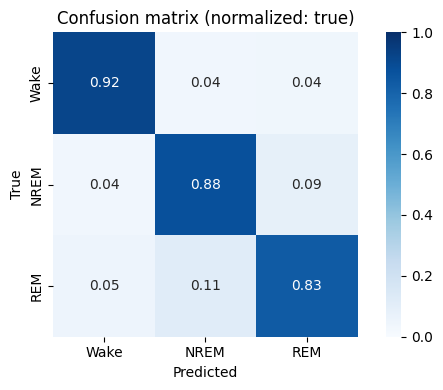

----- SMOOTHED PREDICTIONS (median kernel=5) -----
              precision    recall  f1-score   support

        Wake      0.975     0.924     0.948     37418
        NREM      0.920     0.933     0.927     35045
         REM      0.681     0.844     0.754      6042

    accuracy                          0.922     78505
   macro avg      0.858     0.900     0.876     78505
weighted avg      0.928     0.922     0.924     78505



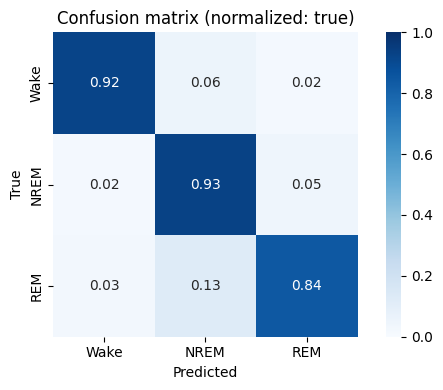

In [139]:
from sklearn.linear_model import LogisticRegression

clf =  LogisticRegression(
        solver="lbfgs",
        class_weight="balanced",
        C=0.1,             # stronger regularization than default 1.0
        max_iter=2000,
        tol=1e-3,
    )

# train model
clf.fit(X_tr_lr, y_tr_enc)

# raw + your own smoothing (already done)
y_pred = clf.predict(X_va_lr)
y_pred_enc, y_pred_smoothed_enc = evaluate_model(y_pred, y_va_enc, median_kernel=5)  # returns aligned arrays

animal_id
A1    22.145556
B2    17.081111
D3    23.997778
D5    23.998889
Name: hours_total, dtype: float64


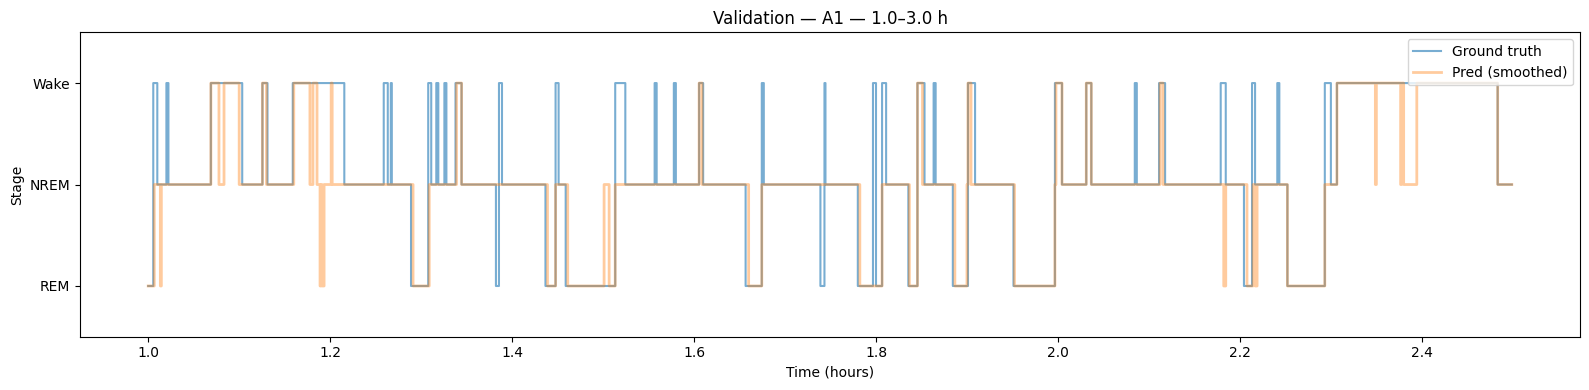

In [140]:
# 1) Build df once for the validation set
groups_va = np.asarray(groups)[idx_va]
df_val = make_val_df(groups_va, y_va_enc, y_pred_enc, y_pred_smoothed_enc, epoch_len_sec=4.0)

# (Optional) see available animals and durations
summary = df_val.groupby("animal_id")["time_s"].max().div(3600).rename("hours_total")
print(summary.head())

# 2) Choose an animal and a time window (in hours)
animal = summary.index[0]     # pick one, or any known animal_id
win = subset_window(df_val, animal_id=animal, start_h=1.0, duration_h=1.5)

# 3) Plot
plot_hypnogram_window(
    times_s=win["times_s"],
    y_true=win["y_true"],
    y_pred=None,#win["y_pred"],
    y_pred_smooth=win["y_pred_sm"],
    title=f"Validation — {animal} — {1.0:.1f}–{1.0+2.0:.1f} h",
)

----- RAW PREDICTIONS -----
              precision    recall  f1-score   support

        Wake      0.956     0.919     0.937     37418
        NREM      0.938     0.872     0.903     35045
         REM      0.509     0.836     0.632      6042

    accuracy                          0.892     78505
   macro avg      0.801     0.876     0.824     78505
weighted avg      0.913     0.892     0.899     78505



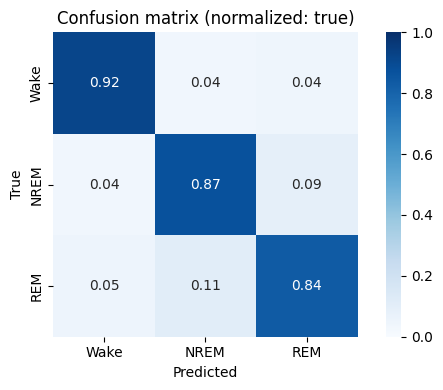

----- SMOOTHED PREDICTIONS (median kernel=5) -----
              precision    recall  f1-score   support

        Wake      0.974     0.923     0.948     37418
        NREM      0.920     0.930     0.925     35045
         REM      0.669     0.845     0.747      6042

    accuracy                          0.920     78505
   macro avg      0.854     0.899     0.873     78505
weighted avg      0.926     0.920     0.922     78505



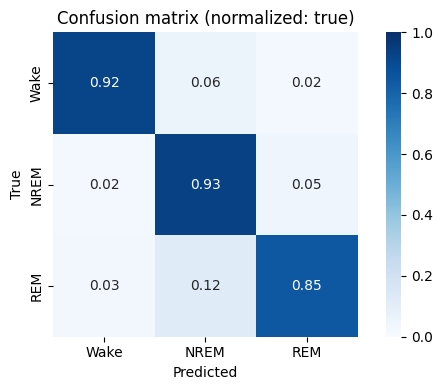

(array([1, 1, 1, ..., 0, 0, 0]), array([1, 1, 1, ..., 0, 0, 0]))

In [134]:
clf.fit(X_tr_xgb, y_tr_enc)
y_pred = clf.predict(X_va_xgb)

evaluate_model(y_pred, y_va_enc, median_kernel=5)

### Test set performance

              precision    recall  f1-score   support

        Wake      0.900     0.878     0.889     30169
        NREM      0.960     0.891     0.924     41007
         REM      0.514     0.799     0.626      6640

    accuracy                          0.878     77816
   macro avg      0.791     0.856     0.813     77816
weighted avg      0.899     0.878     0.885     77816



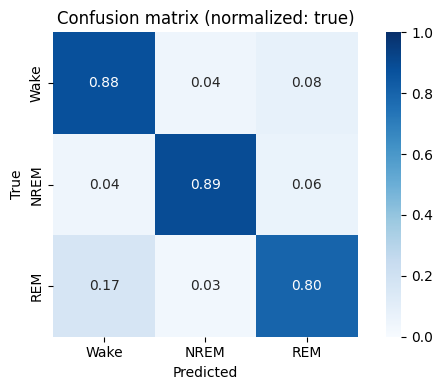

In [56]:
y_pred = clf.predict(X_te_xgb)
y_pred = decode_stages(y_pred)
y_te_dec = decode_stages(y_te_enc)

print(classification_report(
    y_te_dec, y_pred,
    labels=CLASS_ORDER,
    digits=3,
    zero_division=0            
))

plot_confusion_matrix(y_te_dec, y_pred, labels=CLASS_ORDER, normalize='true')

## XGBoost

In [28]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from collections import Counter

# --- per-class sample weights for imbalance (multiclass) ---
cnt = Counter(y_tr_enc)
class_weight = {k: len(y_tr_enc) / (len(cnt) * cnt[k]) for k in cnt}
w_tr = np.array([class_weight[c] for c in y_tr_enc], dtype=np.float32)

# --- model ---
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    tree_method="hist",      # fast + memory efficient
    eval_metric="mlogloss",
    random_state=0,
    n_jobs=-1,
)

xgb.fit(
    X_tr_xgb, y_tr_enc,
    sample_weight=w_tr,
    eval_set=[(X_va_xgb, y_va_enc)],
    verbose=False
)

# Evaluate on validation animals
y_pred_enc = xgb.predict(X_va_xgb)
y_pred = decode_stages(y_pred_enc)
y_va_dec = decode_stages(y_va_enc)

print(classification_report(
    y_va_dec, y_pred,
    labels=CLASS_ORDER,
    digits=3,
    zero_division=0            
))

plot_confusion_matrix(y_va_dec, y_pred, labels=CLASS_ORDER, normalize='true')

KeyboardInterrupt: 

## Experiments:

1. Using one EEG-channel as input (just stack spectrogram)
2. Using multiple channels (mean aggregations)
3. Multitaper spectrograms
4. Same pre-processing as Brodersen et al, 2024
5. Nonlinear models:
    - XGBoost
    - Small MLP
6. 2D-CNN
7. Prediction smoothing

## Linear Discriminant Analysis

----- RAW PREDICTIONS -----
              precision    recall  f1-score   support

        Wake      0.971     0.922     0.946     37418
        NREM      0.895     0.958     0.926     35045
         REM      0.745     0.673     0.707      6042

    accuracy                          0.919     78505
   macro avg      0.870     0.851     0.860     78505
weighted avg      0.920     0.919     0.919     78505



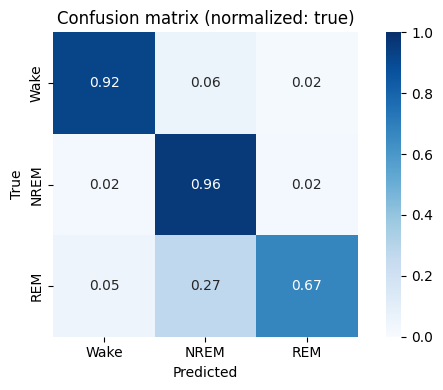

In [46]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

clf.fit(X_tr_xgb, y_tr_enc)
y_pred = clf.predict(X_va_xgb)

evaluate_model(y_pred, y_va_enc, median_kernel=5)

## MLP

Iteration 1, loss = 0.27056346
Iteration 2, loss = 0.19432832
Iteration 3, loss = 0.17799258
Iteration 4, loss = 0.16911747
Iteration 5, loss = 0.16299634
Iteration 6, loss = 0.15598044
Iteration 7, loss = 0.15337186
Iteration 8, loss = 0.14748016
Iteration 9, loss = 0.14486287
Iteration 10, loss = 0.14123229
Iteration 11, loss = 0.13701995
Iteration 12, loss = 0.13562884
Iteration 13, loss = 0.13193404
Iteration 14, loss = 0.12953243
Iteration 15, loss = 0.12467729
Iteration 16, loss = 0.12150541
Iteration 17, loss = 0.12026125
Iteration 18, loss = 0.11793750
Iteration 19, loss = 0.11287121
Iteration 20, loss = 0.11124409
Iteration 21, loss = 0.10756574
Iteration 22, loss = 0.10569874
Iteration 23, loss = 0.10210309
Iteration 24, loss = 0.09878624
Iteration 25, loss = 0.09638672
Iteration 26, loss = 0.09361343
Iteration 27, loss = 0.09040159
Iteration 28, loss = 0.08671010
Iteration 29, loss = 0.08405296
Iteration 30, loss = 0.08178566
Iteration 31, loss = 0.07970860
Iteration 32, los

c:\Users\MDBI\AppData\Local\miniforge3\envs\eeg-data-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


----- RAW PREDICTIONS -----
              precision    recall  f1-score   support

        Wake      0.960     0.946     0.953     37418
        NREM      0.915     0.937     0.926     35045
         REM      0.737     0.702     0.719      6042

    accuracy                          0.923     78505
   macro avg      0.871     0.862     0.866     78505
weighted avg      0.923     0.923     0.923     78505



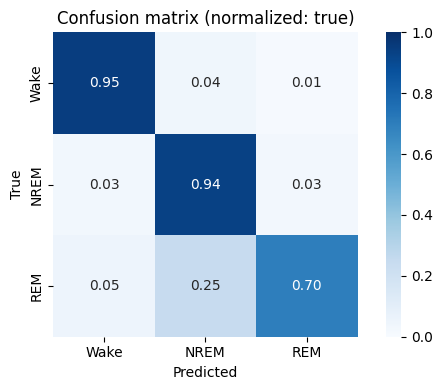

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(256, 128), activation="relu",
                    alpha=1e-4, batch_size=1024, max_iter=50, verbose=True)


mlp.fit(X_tr_xgb, y_tr_enc)
y_pred = mlp.predict(X_va_xgb)

evaluate_model(y_pred, y_va_enc, median_kernel=5)

ValueError: x, y, and format string must not be None

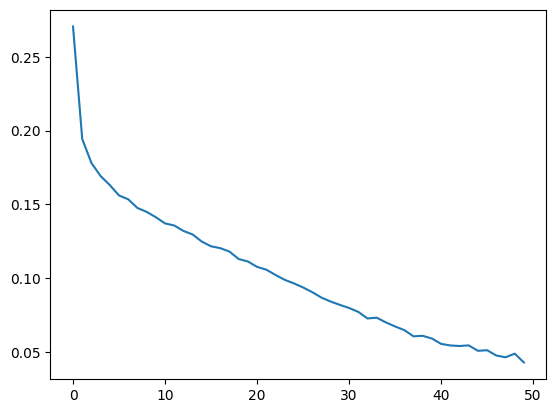

In [48]:
train_loss = mlp.loss_curve_
val_loss = mlp.validation_scores_

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Score")
plt.show()

In [51]:
mlp.validation_scores_